# NetLogo calibration with NL4Py and DEAP

In this example we use the DEAP library in combination with NL4Py to calibrate the Wolf Sheep Predation model using a simple evolutionary algorithm provided by DEAP.

In this experiment, we calibrate the model to find the best parameter configuration able to produce a near-equilibrium state over the first 1000 simulation ticks of the Wolf Sheep Predation model. In other words, the parameters that cause the populations of both wolves and sheep to vary as little as possilbe over the simulation run. 

In [2]:
import random
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

# In this experiment we intend to maximize fitness. Fitness is the measure of population stability, 
#  an indicator of equilibrium in the Wolf Sheep Predation model.
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# An EA Individual is essentially a list of paramter values for our calibration purposes. Through 
#  calibration, we intend to find the Individual that produces the highest fitness, or the most
#  stable population dynamics.
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
# Use nl4py to find the parameter names and ranges
import nl4py
# Start the NetLogoControllerServer.
nl4py.startServer("/home/ubuntu/NetLogo 6.0.3/")
# Create a HeadlessWorkspace to read in the parameter names and ranges.
n = nl4py.newNetLogoHeadlessWorkspace()
# Open the model
n.openModel("Wolf Sheep Predation.nlogo")
# Get the parameter names and ranges.
parameterNames = n.getParamNames()
parameterRanges = n.getParamRanges()
parameterInitializers = []
# Iterate over the names and ranges and create DEAP initializers for all the parameters of the model
for parameterName, parameterRange in zip(parameterNames, parameterRanges):
    parameterName = ''.join(filter(str.isalnum, str(parameterName)))
    if len(parameterRange) == 3:
        toolbox.register(parameterName, random.randrange, parameterRange[0], parameterRange[2], parameterRange[1]) #start stop step
        parameterInitializers.append(eval("toolbox."+str(parameterName)))
# Define the "individual" function in the DEAP toolbox which creates an Individual with a list of parameters
#  within the range specified by the NetLogo model interface.
toolbox.register("individual", tools.initCycle, creator.Individual, tuple(parameterInitializers))
# Define the "population" function in the DEAP toolbox
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Define hyperparameters of the evolutionary algorithm
toolbox.register("mate", tools.cxTwoPoint)
lowerBounds = [row[1] for row in parameterRanges[:-2]]
upperBounds = [row[2] for row in parameterRanges[:-2]]
toolbox.register("mutate", tools.mutUniformInt, low = lowerBounds, up = upperBounds, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)


Dependencies installed successfully! 
Start the NetLogoControllerServer using nl4py.startServer()
Shutting down old server instance...
Server started.


Next, we define a simulation run. This involves:
1. starting a NetLogoHeadlessWorkspace through NL4Py, 
2. opening the Wolf Sheep Predation model, 
3. setting the parameters to the values of the EA individual, 
4. running the simulation
5. calculating the metric 

We define the metric as the stability of the population counts of the two species, without either going into extinction. for this we use first order derivatives per simulation time step and a heavy side function to score extinction as 0. High scores indicate more stable populations (closer to complete equilibrium). Please see the Sensitivity analysis Jupyter notebook for a mode detailed description of this calculation.

In [3]:
import time
import pandas as pd
import numpy as np
def simulate(workspace_,names,values):
    workspace_.command("stop")
    for name, value in zip(names, values):
        cmd = 'set {0} {1}'.format(name, value)
        workspace_.command(cmd)
    workspace_.command('set model-version "sheep-wolves-grass"')
    workspace_.command('setup')
    workspace_.scheduleReportersAndRun(["ticks",'count sheep','count wolves'], 0,1,1000,"go")    
    newResults = []
    while(len(newResults) == 0):
        newResults = workspace_.getScheduledReporterResults()
        if len(newResults) > 0:
            ###Process simulation results###
            df = pd.DataFrame(newResults)
            sheep_pop = pd.to_numeric(df.iloc[:,1])
            wolves_pop = pd.to_numeric(df.iloc[:,2])
            #since time is in simulation ticks, this is the absolute rate of change of sheep population.
            dsheep_dt = sheep_pop.diff().abs()
            #since time is in simulation ticks, this is the absolute rate of change of wolf population.
            dwolves_dt = wolves_pop.diff().abs()   
            #Find population stabilities over time for species as reciprocal of derivatives multiplied by
            # a heavyside function ensuring extinction is scored at 0.
            population_stability_sheep = np.divide(1,(dsheep_dt + 0.000001)).mul(np.where(sheep_pop==0,0,1))
            population_stability_wolves = np.divide(1,(dwolves_dt + 0.000001)).mul(np.where(wolves_pop==0,0,1))
            #Find total population stability over time as the mean of population stabilities for both species.
            population_stability_total = (population_stability_sheep + population_stability_wolves) / 2
            #the aggregate metric is the mean, total population stability over time
            aggregate_metric = population_stability_total.sum()/len(population_stability_total)
            ###Done processing simulation results###
            workspace_.command("stop")
            return aggregate_metric,
        time.sleep(2)

We setup Headless Workspaces for each EA individual. The HeadlessWorkspaces are reusable per population and are tracked as to when they are free to run another model evaluation

In [4]:
nl4py.deleteAllHeadlessWorkspaces()
POP = 200
freeWorkspaces = []
for i in range(0,POP):
    n = nl4py.newNetLogoHeadlessWorkspace()
    n.openModel('Wolf Sheep Predation.nlogo')
    freeWorkspaces.append(n)

The EA individual evaluation is defined as a simulation run of the model for the parameter values specified and reports the total stability metric of the population. 

In [5]:
def evaluateWolfSheepPredation(individual):
    n = freeWorkspaces[0]
    freeWorkspaces.remove(n)
    result = simulate(n,parameterNames,individual)
    freeWorkspaces.append(n)
    return result
toolbox.register("evaluate", evaluateWolfSheepPredation)

We now define the statistics we are interested in tracking and run the EA with custom hyperparameters.

In [6]:
import multiprocessing
from multiprocessing.pool import ThreadPool
pool = ThreadPool(multiprocessing.cpu_count())
toolbox.register("map", pool.map)
stats = tools.Statistics(key = lambda ind: ind.fitness.values)
stats.register("max",np.max)
stats.register("mean",np.mean)
hof = tools.HallOfFame(1) 
final_pop, log= algorithms.eaSimple(toolbox.population(n=POP), toolbox, cxpb=0.8, mutpb=0.2, ngen=100,stats = stats,halloffame = hof)

gen	nevals	max   	mean   
0  	200   	403000	44242.6
1  	172   	461000	78005.1
2  	164   	449500	114500 
3  	160   	568500	178963 
4  	170   	571500	221520 
5  	176   	572000	240858 
6  	164   	595000	277110 
7  	175   	713000	302160 
8  	161   	649500	345975 
9  	160   	640500	391990 
10 	173   	656500	438028 
11 	158   	652000	475688 
12 	177   	665500	497433 
13 	171   	645500	497688 
14 	166   	694000	519728 
15 	167   	725500	530853 
16 	164   	710000	538400 
17 	155   	718000	546930 
18 	173   	718000	557653 
19 	166   	722500	566160 
20 	175   	724500	581378 
21 	161   	733500	573900 
22 	171   	758500	591253 
23 	175   	733500	588123 
24 	172   	733500	600315 
25 	169   	744000	618510 
26 	156   	744000	621023 
27 	178   	744000	617960 
28 	165   	739500	629283 
29 	166   	739500	617900 
30 	171   	739500	612688 
31 	170   	748000	619953 
32 	176   	739500	602310 
33 	164   	734500	625908 
34 	162   	727500	619625 
35 	180   	727500	631265 
36 	176   	741000	636455 
37 	171   	7

In [10]:
print("The best individual over the complete calibration:")
print(parameterNames)
print(hof)

The best individual over the complete calibration:
['initial-number-sheep', 'sheep-gain-from-food', 'sheep-reproduce', 'initial-number-wolves', 'wolf-gain-from-food', 'wolf-reproduce', 'grass-regrowth-time', 'show-energy?', 'model-version']
[[245, 3, 1, 9, 74, 1, 97]]


We can now run and visualize the results...

In [11]:
app = nl4py.NetLogoApp()
app.openModel("./Wolf Sheep Predation.nlogo")
for name, value in zip(parameterNames, hof[0]):
    app.command('set {0} {1}'.format(name, value))
app.command("setup")
app.command("repeat 1000 [go]")

And plot the convergence progress by the EA

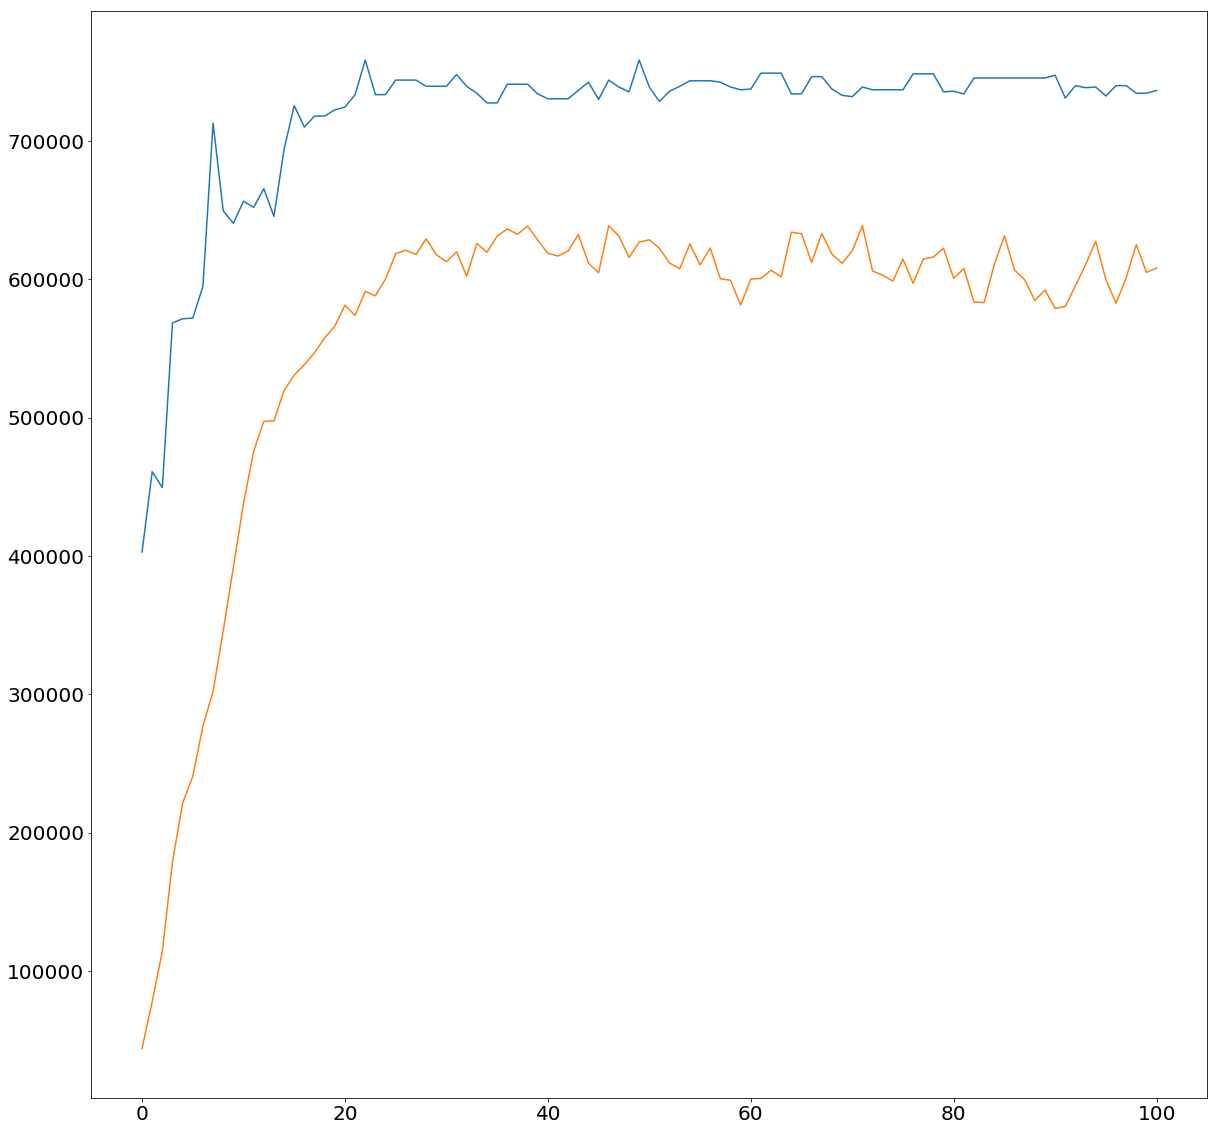

In [13]:
app.closeModel()
convergence_progress = pd.DataFrame(log)[['max','mean']]
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 20.0
fig = plt.figure(figsize = [20,20])
ax = fig.add_subplot(111)
plot = ax.plot(convergence_progress)
fig.savefig("CalibrationConvergenceProgress.png")